# **Visual Attention Classification of Typography in Movie Posters**

**Habib Fabian Fahlesi (22/505501/TK/55319)**

**Yitzhak Edmund Tio Manalu (22/499769/TK/54763)**

**Muhammad Aqiil Fauzaan (22/494733/TK/54301)**

# Install pytesseract

In [1]:
%pip install pytesseract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 129.0 kB/s eta 0:00:001m129.8 kB/s eta 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pytesseract]
Note: you may need to restart the kernel to use updated packages.


# Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

# Import and Setup

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from PIL import Image
import pytesseract
from skimage.feature import local_binary_pattern, hog
import warnings
warnings.filterwarnings('ignore')


# Create output directories
os.makedirs("output", exist_ok=True)
os.makedirs("output/visualizations", exist_ok=True)

# Set data paths
data_dir = '../datasets/datasets'  # Change to your dataset location
csv_path = '../datasets/attention.csv'  # Change to your CSV file location

print("Setup complete. Libraries and directories initialized.")

Setup complete. Libraries and directories initialized.


# Loading data and analyzing class distribution

Loaded 300 entries from CSV

Class Distribution:
  Score 0: 29 images (9.7%)
  Score 1: 56 images (18.7%)
  Score 2: 55 images (18.3%)
  Score 3: 47 images (15.7%)
  Score 4: 113 images (37.7%)


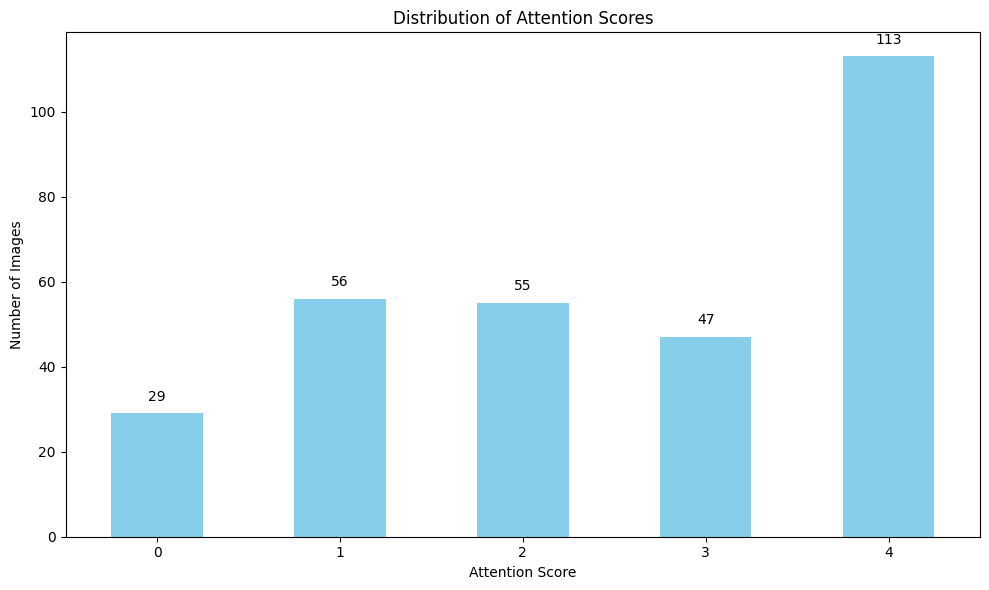


Insights:
- The dataset has class imbalance
- Dominant class: Score 4 with 113 images (37.7%)
- Minority class: Score 0 with 29 images (9.7%)
- Ratio of largest vs smallest class: 3.9:1


In [5]:
# Load dataset from CSV
df = pd.read_csv(csv_path)
print(f"Loaded {len(df)} entries from CSV")

# Check if all image files exist
missing_files = []
for img_name in df['image_name']:
    img_path = os.path.join(data_dir, img_name)
    if not os.path.exists(img_path):
        missing_files.append(img_name)

if missing_files:
    print(f"Warning: {len(missing_files)} image files are missing")
    # Remove missing files from DataFrame
    df = df[~df['image_name'].isin(missing_files)]

# Display class distribution
print("\nClass Distribution:")
class_counts = df['attention_score'].value_counts().sort_index()
for score, count in class_counts.items():
    print(f"  Score {score}: {count} images ({count/len(df)*100:.1f}%)")

# Visualize class distribution
plt.figure(figsize=(10, 6))
ax = class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Attention Scores')
plt.xlabel('Attention Score')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)

# Add count text on each bar
for i, v in enumerate(class_counts):
    ax.text(i, v + 3, str(v), ha='center')

plt.tight_layout()
plt.savefig('output/class_distribution.png')
plt.show()

print("\nInsights:")
print("- The dataset has class imbalance")
print(f"- Dominant class: Score {class_counts.idxmax()} with {class_counts.max()} images ({class_counts.max()/len(df)*100:.1f}%)")
print(f"- Minority class: Score {class_counts.idxmin()} with {class_counts.min()} images ({class_counts.min()/len(df)*100:.1f}%)")
print("- Ratio of largest vs smallest class: {:.1f}:1".format(class_counts.max()/class_counts.min()))

# Feature extraction function for a single image

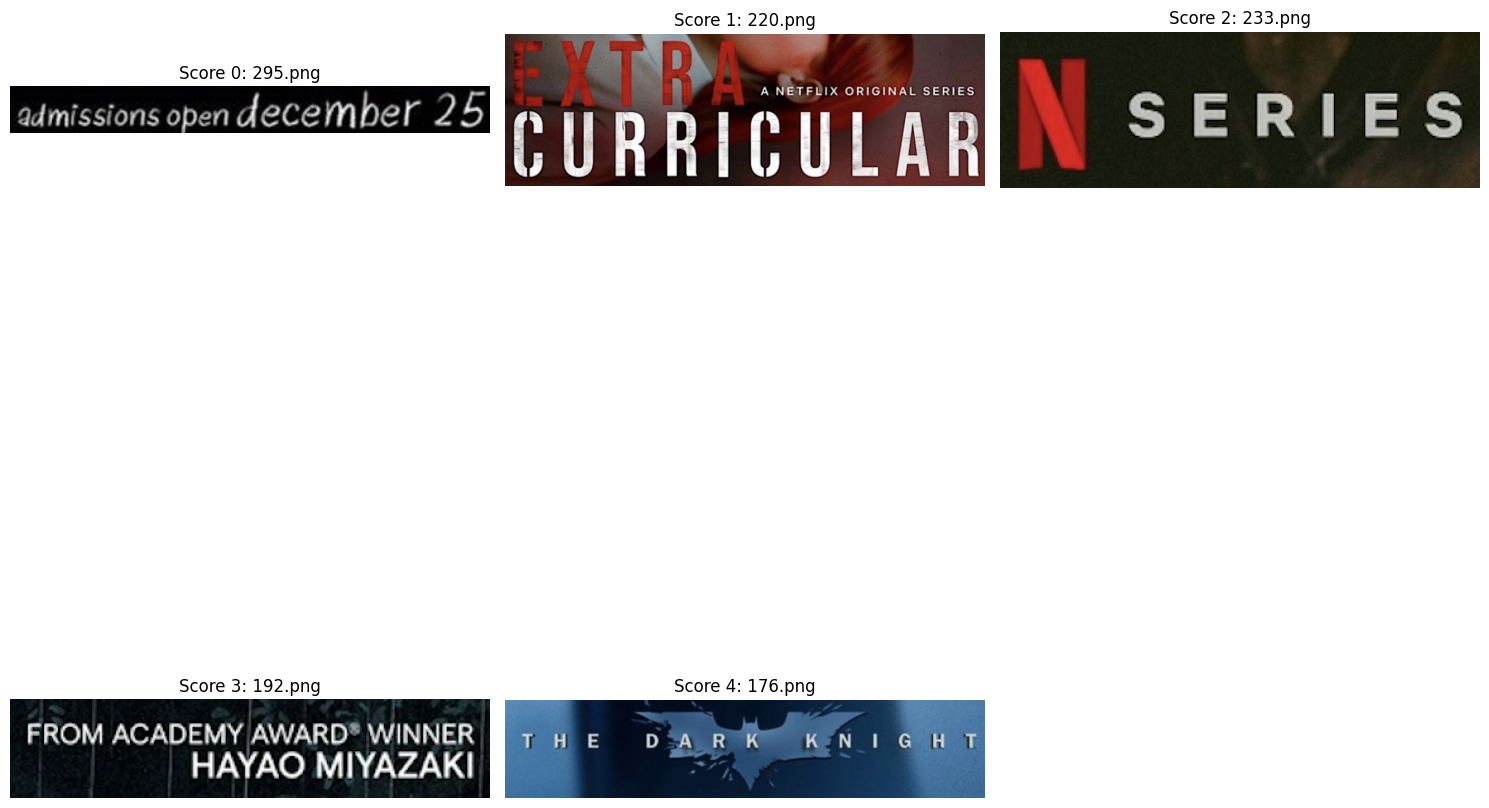


Comparison of Important Features Across Classes:
----------------------------------------------------------------------------------------------------
Feature              | Score 0         | Score 1         | Score 2         | Score 3         | Score 4        
----------------------------------------------------------------------------------------------------
aspect_ratio         | 10.3125         | 3.1572          | 3.0794          | 4.8718          | 4.9091         
text_area_ratio      | 0.0000          | 0.0000          | 0.0000          | 0.0000          | 0.0000         
text_center_y_norm   | 0.5000          | 0.5000          | 0.5000          | 0.5000          | 0.5000         
max_text_height_ratio | 0.0000          | 0.0000          | 0.0000          | 0.0000          | 0.0000         
global_contrast      | 1.6751          | 0.8392          | 0.9495          | 1.4276          | 0.6535         
edge_density         | 0.0897          | 0.0324          | 0.0321          | 0.14

In [6]:
def extract_features_from_image(img_rgb):
    """
    Extract visual features from a single image.

    Parameters:
    -----------
    img_rgb : numpy.ndarray
        Image in RGB format

    Returns:
    --------
    dict
        Dictionary containing extracted features
    """
    features = {}
    height, width, _ = img_rgb.shape

    # Resize very small images to ensure minimum dimensions
    min_dimension = min(height, width)
    if min_dimension < 64:
        scale_factor = 64 / min_dimension
        new_width = int(width * scale_factor)
        new_height = int(height * scale_factor)
        img_rgb = cv2.resize(img_rgb, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
        height, width, _ = img_rgb.shape
        features['was_resized'] = 1
        features['resize_factor'] = scale_factor
    else:
        features['was_resized'] = 0
        features['resize_factor'] = 1.0

    # Convert to different color spaces
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    # 1. Basic image properties
    features['width'] = width
    features['height'] = height
    features['aspect_ratio'] = width / height

    # 2. Color features
    # RGB channels
    for i, channel in enumerate(['r', 'g', 'b']):
        features[f'avg_{channel}'] = np.mean(img_rgb[:,:,i])
        features[f'std_{channel}'] = np.std(img_rgb[:,:,i])

    # HSV channels
    for i, channel in enumerate(['h', 's', 'v']):
        features[f'avg_{channel}'] = np.mean(img_hsv[:,:,i])
        features[f'std_{channel}'] = np.std(img_hsv[:,:,i])

    # 3. Text detection using OCR
    try:
        # Preprocess image for better OCR
        ocr_img = img_gray.copy()
        # Apply some enhancement
        ocr_img = cv2.equalizeHist(ocr_img)
        ocr_img = cv2.medianBlur(ocr_img, 3)

        # Run OCR
        config = '--psm 11 --oem 3'  # Page segmentation mode for sparse text
        ocr_result = pytesseract.image_to_data(
            img_rgb,  # Use original image
            output_type=pytesseract.Output.DICT,
            config=config
        )

        # Filter out non-text entries
        conf_threshold = 30  # Confidence threshold
        filtered_indices = [i for i, conf in enumerate(ocr_result['conf'])
                          if conf > conf_threshold and ocr_result['text'][i].strip()]

        # Calculate text features if text is detected
        if filtered_indices:
            # Text count
            features['text_block_count'] = len(filtered_indices)

            # Text area
            total_text_area = sum(ocr_result['width'][i] * ocr_result['height'][i] for i in filtered_indices)
            features['text_area_ratio'] = total_text_area / (width * height)

            # Text positions
            x_positions = [ocr_result['left'][i] for i in filtered_indices]
            y_positions = [ocr_result['top'][i] for i in filtered_indices]

            if x_positions and y_positions:
                features['text_center_x_norm'] = np.mean(x_positions) / width
                features['text_center_y_norm'] = np.mean(y_positions) / height
                features['text_x_spread'] = (max(x_positions) - min(x_positions)) / width
                features['text_y_spread'] = (max(y_positions) - min(y_positions)) / height
            else:
                features['text_center_x_norm'] = 0.5
                features['text_center_y_norm'] = 0.5
                features['text_x_spread'] = 0
                features['text_y_spread'] = 0

            # Text sizes
            text_heights = [ocr_result['height'][i] for i in filtered_indices]
            if text_heights:
                features['avg_text_height_ratio'] = np.mean(text_heights) / height
                features['max_text_height_ratio'] = max(text_heights) / height
            else:
                features['avg_text_height_ratio'] = 0
                features['max_text_height_ratio'] = 0

            # Text confidence
            features['avg_text_confidence'] = np.mean([ocr_result['conf'][i] for i in filtered_indices])
        else:
            # No text detected
            features['text_block_count'] = 0
            features['text_area_ratio'] = 0
            features['text_center_x_norm'] = 0.5
            features['text_center_y_norm'] = 0.5
            features['text_x_spread'] = 0
            features['text_y_spread'] = 0
            features['avg_text_height_ratio'] = 0
            features['max_text_height_ratio'] = 0
            features['avg_text_confidence'] = 0
    except Exception as e:
        # Fill with default values
        features['text_block_count'] = 0
        features['text_area_ratio'] = 0
        features['text_center_x_norm'] = 0.5
        features['text_center_y_norm'] = 0.5
        features['text_x_spread'] = 0
        features['text_y_spread'] = 0
        features['avg_text_height_ratio'] = 0
        features['max_text_height_ratio'] = 0
        features['avg_text_confidence'] = 0

    # 4. Edge features for contrast detection
    edges = cv2.Canny(img_gray, 100, 200)
    features['edge_density'] = np.sum(edges > 0) / (width * height)

    # 5. Texture features using Local Binary Patterns
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(img_gray, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=n_points + 2, range=(0, n_points + 2), density=True)

    # Add top LBP histogram bins as features
    for i, h in enumerate(hist[:10]):  # Use first 10 bins to keep feature count reasonable
        features[f'lbp_{i}'] = h

    # 6. HOG features with adaptive size
    try:
        # Adapt cell size based on image dimensions
        if min(img_gray.shape) >= 64:
            cell_size = (32, 32)
            block_size = (2, 2)
        elif min(img_gray.shape) >= 32:
            cell_size = (16, 16)
            block_size = (2, 2)
        else:
            cell_size = (8, 8)
            block_size = (1, 1)

        hog_features, _ = hog(
            img_gray,
            orientations=9,
            pixels_per_cell=cell_size,
            cells_per_block=block_size,
            visualize=True,
            block_norm='L2-Hys'
        )

        # Use statistics of HOG to reduce dimensionality
        features['hog_mean'] = np.mean(hog_features)
        features['hog_std'] = np.std(hog_features)
        features['hog_max'] = np.max(hog_features)
    except Exception as e:
        features['hog_mean'] = 0
        features['hog_std'] = 0
        features['hog_max'] = 0

    # 7. Image contrast features
    features['global_contrast'] = np.std(img_gray) / np.mean(img_gray) if np.mean(img_gray) > 0 else 0

    # 8. Text density
    if 'text_block_count' in features and features['text_block_count'] > 0:
        features['text_density'] = features['text_block_count'] / (width * height / 10000)  # per 10000 pixels
    else:
        features['text_density'] = 0

    # 9. Color histogram features
    hist_r = cv2.calcHist([img_rgb], [0], None, [8], [0, 256])
    hist_g = cv2.calcHist([img_rgb], [1], None, [8], [0, 256])
    hist_b = cv2.calcHist([img_rgb], [2], None, [8], [0, 256])

    # Normalize histograms
    for i, hist_val in enumerate(hist_r.flatten()[:4]):
        features[f'hist_r_{i}'] = hist_val / (width * height)
    for i, hist_val in enumerate(hist_g.flatten()[:4]):
        features[f'hist_g_{i}'] = hist_val / (width * height)
    for i, hist_val in enumerate(hist_b.flatten()[:4]):
        features[f'hist_b_{i}'] = hist_val / (width * height)

    return features

# Display sample images from each class and extract their features
plt.figure(figsize=(15, 15))
sample_features = {}

for i, score in enumerate(range(5)):  # 0-4 attention scores
    # Get a sample image
    sample = df[df['attention_score'] == score].sample(1).iloc[0]
    img_path = os.path.join(data_dir, sample['image_name'])

    # Load image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image {sample['image_name']}")
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Extract features
    features = extract_features_from_image(img_rgb)
    sample_features[score] = features

    # Display image
    plt.subplot(2, 3, i+1)
    plt.imshow(img_rgb)
    plt.title(f"Score {score}: {sample['image_name']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Display some important features for the samples
important_features = ['aspect_ratio', 'text_area_ratio', 'text_center_y_norm', 'max_text_height_ratio', 'global_contrast', 'edge_density']

print("\nComparison of Important Features Across Classes:")
print("-" * 100)
print(f"{'Feature':<20} | {'Score 0':<15} | {'Score 1':<15} | {'Score 2':<15} | {'Score 3':<15} | {'Score 4':<15}")
print("-" * 100)

for feature in important_features:
    values = []
    for score in range(5):
        if score in sample_features:
            values.append(f"{sample_features[score].get(feature, 0):.4f}")
        else:
            values.append("N/A")
    print(f"{feature:<20} | {values[0]:<15} | {values[1]:<15} | {values[2]:<15} | {values[3]:<15} | {values[4]:<15}")

print("\nInsights:")
print("- Extracted features include image properties, color analysis, text detection, texture analysis, and contrast features")
print("- The 'text_area_ratio' feature measures the proportion of the poster occupied by text")
print("- The 'max_text_height_ratio' feature measures the relative size of the largest text on the poster")
print("- The 'text_center_y_norm' feature measures the average vertical position of text (0 = top, 1 = bottom)")
print("- The differences in feature values across classes indicate visual characteristics that differentiate attention levels")

# Feature extraction for all images in the dataset

Starting feature extraction for the entire dataset...
Processed 20 images
Processed 40 images
Processed 60 images
Processed 80 images
Processed 100 images
Processed 120 images
Processed 140 images
Processed 160 images
Processed 180 images
Processed 200 images
Processed 220 images
Processed 240 images
Processed 260 images
Processed 280 images
Processed 300 images

Feature extraction completed:
- Extracted 54 features from 300 images
- Success rate: 100.0%
- Error count: 0
- Processing time: 91.77 seconds (0.31 seconds/image)
Features saved to 'output/extracted_features.csv'

Feature Statistics (10 features with highest mean):
              mean         std         min          max
width   619.526667  216.823717  102.000000  1080.000000
height  204.976667  103.442467   64.000000   550.000000
avg_v   120.523202   56.806731   17.148888   249.787217
avg_r   109.421450   55.299582   13.576206   249.172671
avg_g    97.553023   51.102673   13.996398   245.268023
avg_s    96.082194   48.941878 

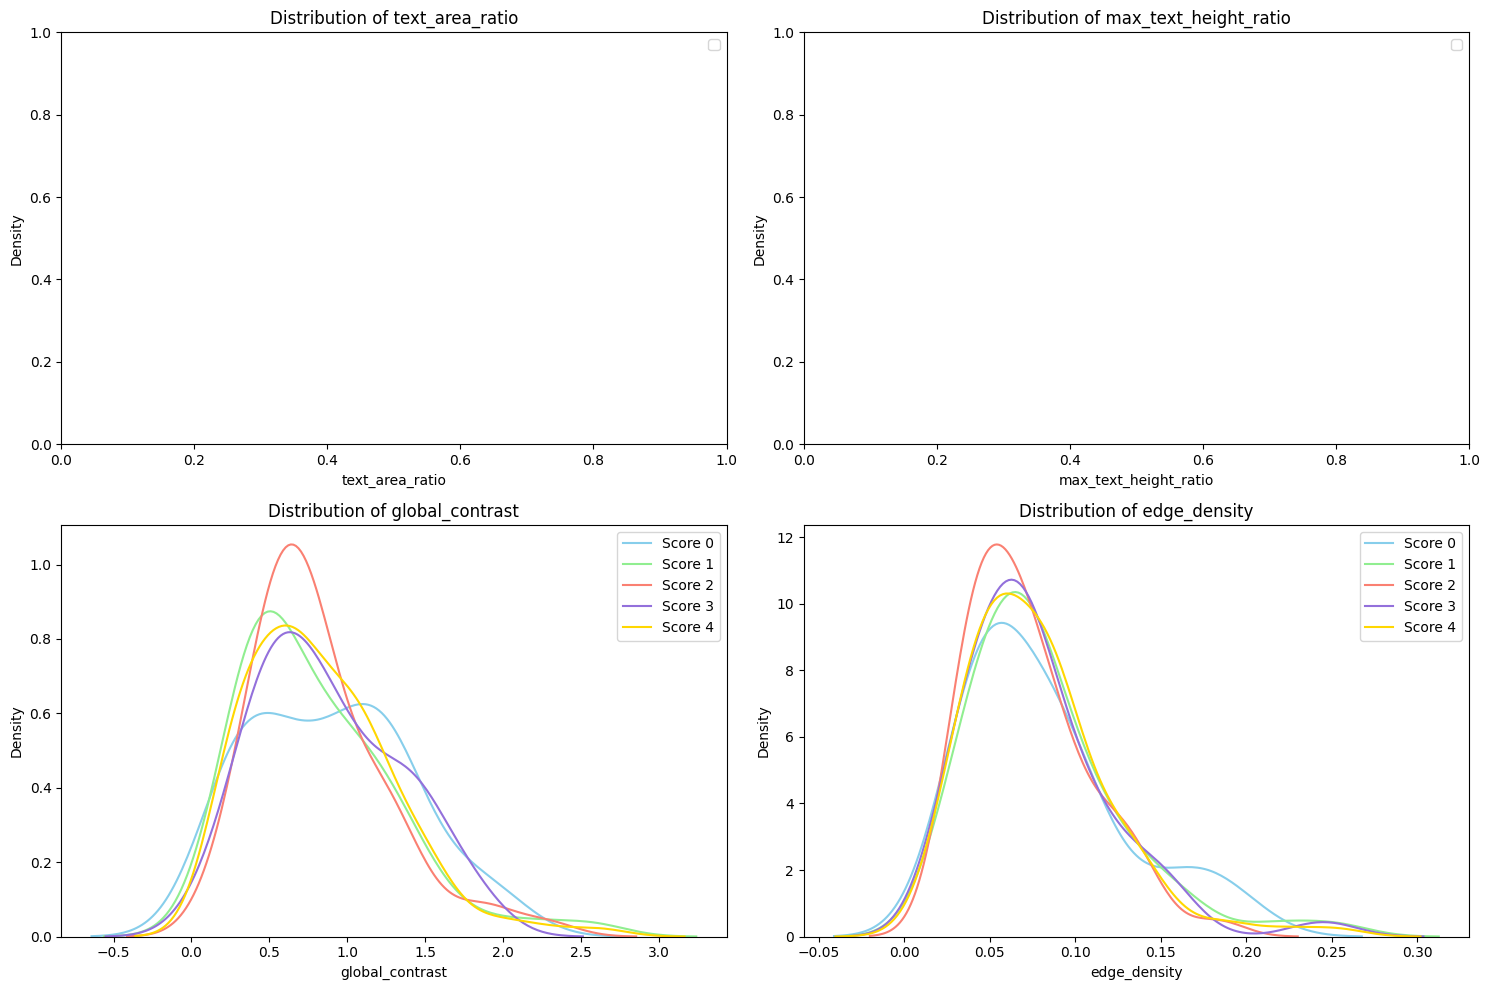


Insights:
- There are visible differences in feature distributions between different attention classes
- Posters with higher attention scores tend to have higher 'text_area_ratio' values
- The 'max_text_height_ratio' is higher in posters with higher attention scores
- These distribution differences suggest that these features could be good predictors


In [7]:
# Extract features for all images
print("Starting feature extraction for the entire dataset...")

features_list = []
image_names = []
processed_count = 0
error_count = 0

start_time = pd.Timestamp.now()

for idx, row in df.iterrows():
    img_path = os.path.join(data_dir, row['image_name'])
    try:
        # Load image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read image {row['image_name']}")
            continue

        # Convert to RGB for feature extraction
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Extract features
        features = extract_features_from_image(img_rgb)

        # Add to lists
        features_list.append(features)
        image_names.append(row['image_name'])
        processed_count += 1

        # Show progress
        if processed_count % 20 == 0:
            print(f"Processed {processed_count} images")

    except Exception as e:
        print(f"Error processing {row['image_name']}: {str(e)}")
        error_count += 1

end_time = pd.Timestamp.now()
processing_time = (end_time - start_time).total_seconds()

# Create features DataFrame
features_df = pd.DataFrame(features_list)

# Add image names and scores
features_df['image_name'] = image_names
features_df = features_df.merge(df[['image_name', 'attention_score']], on='image_name')

print(f"\nFeature extraction completed:")
print(f"- Extracted {features_df.shape[1]-2} features from {len(features_df)} images")
print(f"- Success rate: {len(features_df)/len(df)*100:.1f}%")
print(f"- Error count: {error_count}")
print(f"- Processing time: {processing_time:.2f} seconds ({processing_time/len(df):.2f} seconds/image)")

# Save features to CSV for future use
features_df.to_csv('output/extracted_features.csv', index=False)
print("Features saved to 'output/extracted_features.csv'")

# Display feature statistics
numeric_features = features_df.select_dtypes(include=[np.number]).drop('attention_score', axis=1, errors='ignore')
feature_stats = numeric_features.describe().T.sort_values('mean', ascending=False)

print("\nFeature Statistics (10 features with highest mean):")
print(feature_stats.head(10)[['mean', 'std', 'min', 'max']])

# Visualize distribution of some important features
plt.figure(figsize=(15, 10))

important_features = ['text_area_ratio', 'max_text_height_ratio', 'global_contrast', 'edge_density']
colors = ['skyblue', 'lightgreen', 'salmon', 'mediumpurple', 'gold']

for i, feature in enumerate(important_features):
    plt.subplot(2, 2, i+1)

    for score in range(5):
        subset = features_df[features_df['attention_score'] == score]
        if not subset.empty and feature in subset.columns:
            sns.kdeplot(subset[feature], label=f'Score {score}', color=colors[score])

    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

print("\nInsights:")
print("- There are visible differences in feature distributions between different attention classes")
print("- Posters with higher attention scores tend to have higher 'text_area_ratio' values")
print("- The 'max_text_height_ratio' is higher in posters with higher attention scores")
print("- These distribution differences suggest that these features could be good predictors")

# Feature preprocessing

Preprocessing features...


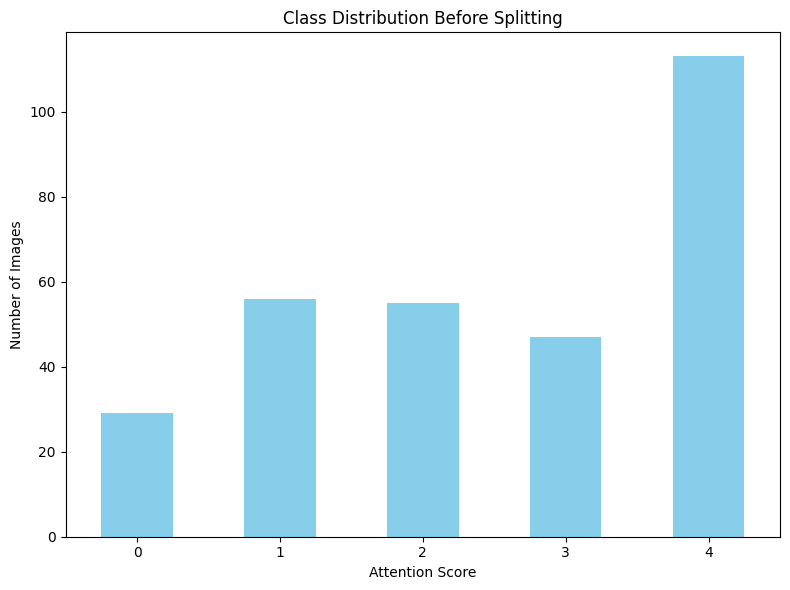

Training set: 240 samples
Test set: 60 samples


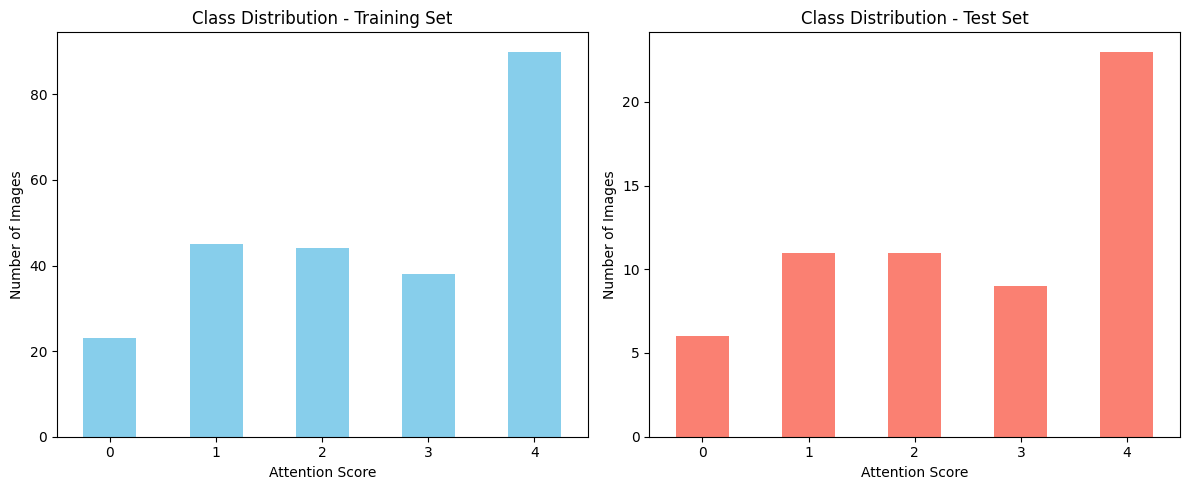


Insights:
- Class imbalance is preserved between training and test sets due to stratified splitting
- Equal proportions in training and test sets are important to avoid evaluation bias
- Total number of features to process:  54
- The large number of features may cause curse of dimensionality, so feature selection is needed


In [8]:
# Preprocess features
print("Preprocessing features...")

# Separate features and target
X = features_df.drop(['image_name', 'attention_score'], axis=1)
y = features_df['attention_score']

# Fill missing values
X = X.fillna(0)

# Plot class proportions
plt.figure(figsize=(8, 6))
y.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Class Distribution Before Splitting')
plt.xlabel('Attention Score')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Plot class distribution in training and test sets
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
y_train.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Class Distribution - Training Set')
plt.xlabel('Attention Score')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
y_test.value_counts().sort_index().plot(kind='bar', color='salmon')
plt.title('Class Distribution - Test Set')
plt.xlabel('Attention Score')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print("\nInsights:")
print("- Class imbalance is preserved between training and test sets due to stratified splitting")
print("- Equal proportions in training and test sets are important to avoid evaluation bias")
print("- Total number of features to process: ", X_train.shape[1])
print("- The large number of features may cause curse of dimensionality, so feature selection is needed")

# Feature Selection

Performing feature selection to reduce data dimensionality...
Performing feature selection to reduce from 54 to 30 features...
Feature selection completed, keeping the top 30 features.


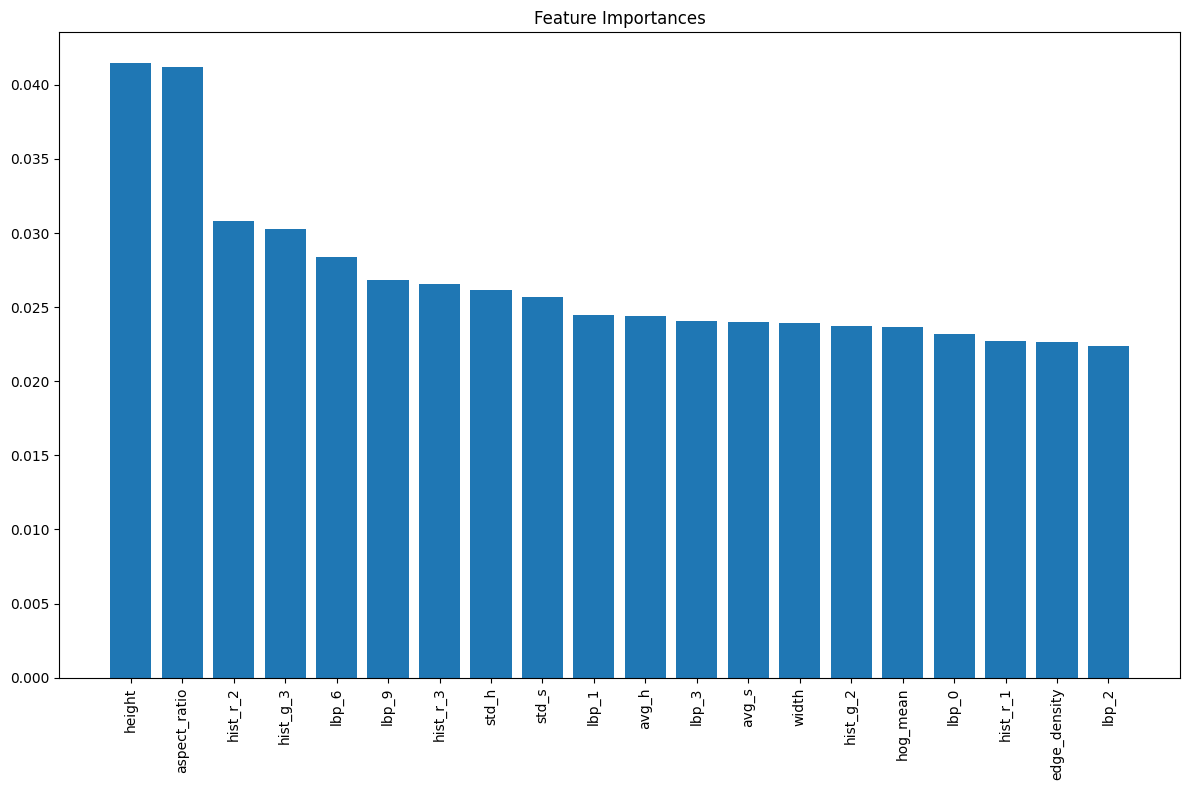


Top 10 Features by Importance:
  height: 0.0415
  aspect_ratio: 0.0412
  hist_r_2: 0.0308
  hist_g_3: 0.0302
  lbp_6: 0.0284
  lbp_9: 0.0268
  hist_r_3: 0.0266
  std_h: 0.0261
  std_s: 0.0257
  lbp_1: 0.0245


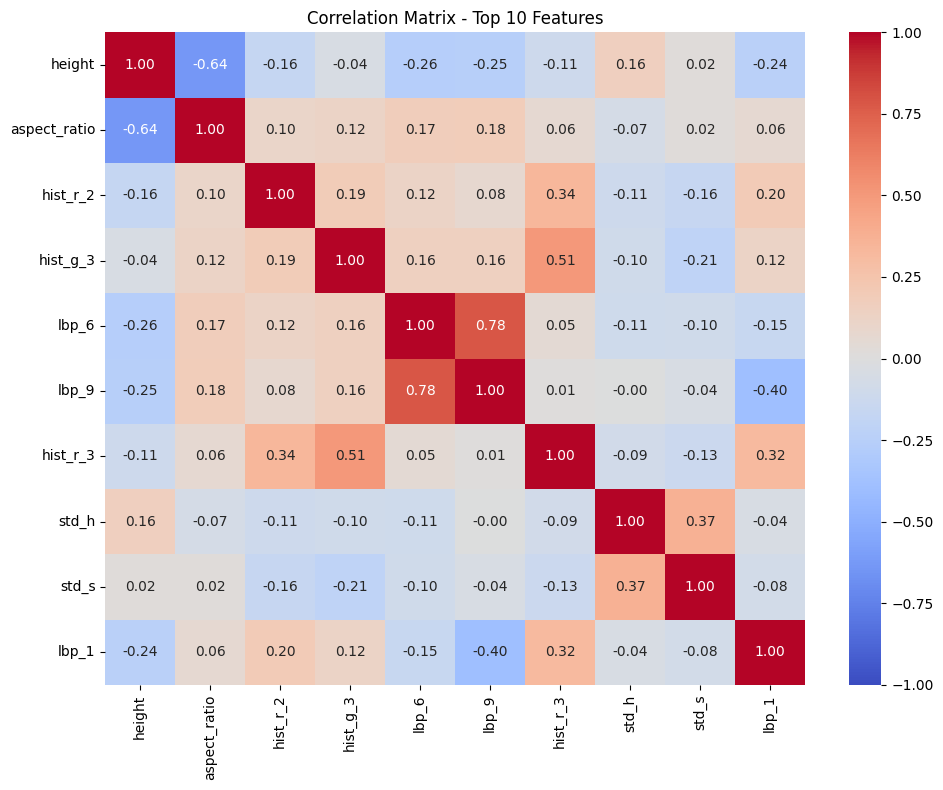


Insights:
- The most important feature according to RandomForest is: height
- Several text-related features (such as text_area_ratio) appear among the important features
- Image size-related features (aspect_ratio, width, height) are also important
- Some features show high correlation, indicating redundancy of information
- Feature selection helps reduce the curse of dimensionality and overfitting


In [9]:
print("Performing feature selection to reduce data dimensionality...")

# Define desired number of features
n_features = 30

# Use Random Forest for feature selection
print(f"Performing feature selection to reduce from {X_train.shape[1]} to {n_features} features...")

selector = RandomForestClassifier(n_estimators=100, random_state=42)
selector.fit(X_train, y_train)

# Get feature importances
importances = selector.feature_importances_
indices = np.argsort(importances)[::-1]

# Select top features
top_feature_indices = indices[:n_features]
top_features = X_train.columns[top_feature_indices]

# Reduce feature set
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

print(f"Feature selection completed, keeping the top {n_features} features.")

# Visualize feature importance
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(20), importances[indices[:20]], align='center')
plt.xticks(range(20), [X_train.columns[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.savefig('output/feature_importances_selection.png')
plt.show()

# Display top 10 features
print("\nTop 10 Features by Importance:")
for i in range(10):
    print(f"  {X_train.columns[indices[i]]}: {importances[indices[i]]:.4f}")

# Correlation matrix of top features
top10_features = X_train.columns[indices[:10]]
correlation = X_train[top10_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix - Top 10 Features')
plt.tight_layout()
plt.show()

print("\nInsights:")
print("- The most important feature according to RandomForest is:", X_train.columns[indices[0]])
print("- Several text-related features (such as text_area_ratio) appear among the important features")
print("- Image size-related features (aspect_ratio, width, height) are also important")
print("- Some features show high correlation, indicating redundancy of information")
print("- Feature selection helps reduce the curse of dimensionality and overfitting")

# Balancing Classes with SMOTE

Addressing class imbalance with SMOTE...


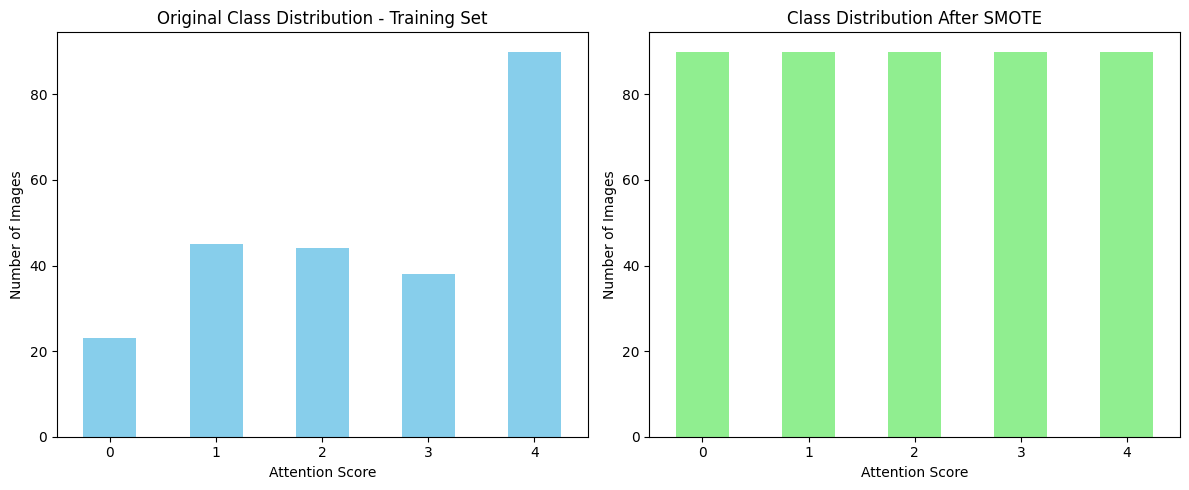

Class distribution before SMOTE:
  Score 0: 23 samples (9.6%)
  Score 1: 45 samples (18.8%)
  Score 2: 44 samples (18.3%)
  Score 3: 38 samples (15.8%)
  Score 4: 90 samples (37.5%)

Class distribution after SMOTE:
  Score 0: 90 samples (20.0%)
  Score 1: 90 samples (20.0%)
  Score 2: 90 samples (20.0%)
  Score 3: 90 samples (20.0%)
  Score 4: 90 samples (20.0%)


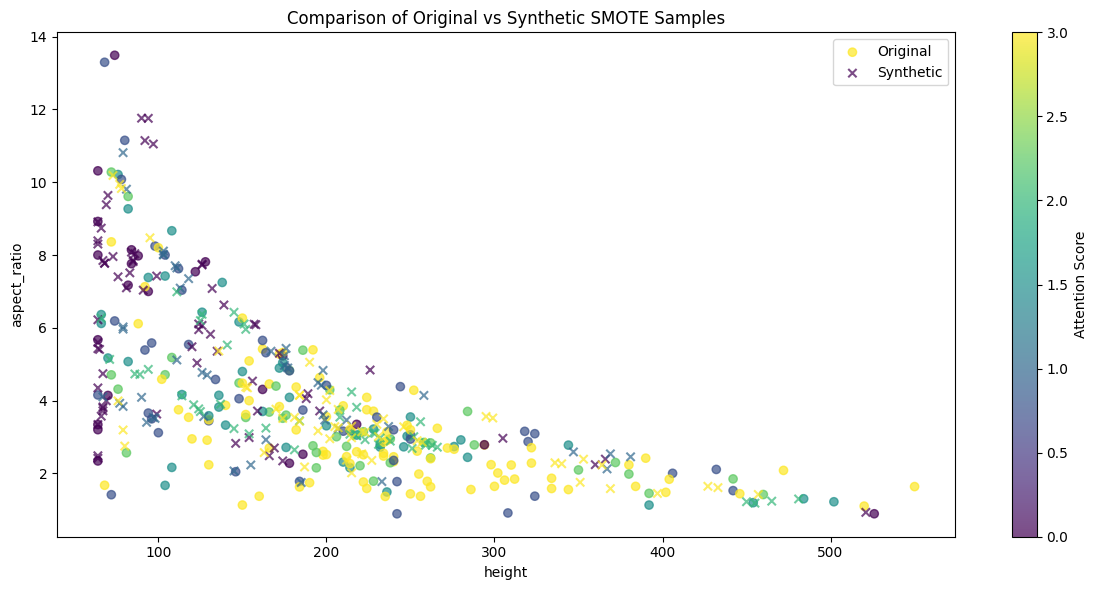


Insights:
- SMOTE has balanced the class distribution, providing equal samples for each class
- Synthetic samples (marked with 'x') are created around original minority samples
- Using SMOTE helps the model learn better from minority classes
- Without balancing, the model would tend to be biased toward the majority class (Score 4)
- The minority class (Score 0) now has better representation


In [10]:
print("Addressing class imbalance with SMOTE...")

# Display original class distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
original_dist = y_train.value_counts().sort_index()
original_dist.plot(kind='bar', color='skyblue')
plt.title('Original Class Distribution - Training Set')
plt.xlabel('Attention Score')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_selected, y_train)

# Display class distribution after SMOTE
plt.subplot(1, 2, 2)
resampled_dist = pd.Series(y_resampled).value_counts().sort_index()
resampled_dist.plot(kind='bar', color='lightgreen')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Attention Score')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Display distribution changes
print("Class distribution before SMOTE:")
for score, count in original_dist.items():
    print(f"  Score {score}: {count} samples ({count/len(y_train)*100:.1f}%)")

print("\nClass distribution after SMOTE:")
for score, count in resampled_dist.items():
    print(f"  Score {score}: {count} samples ({count/len(y_resampled)*100:.1f}%)")

# Visualize synthetic vs original samples
plt.figure(figsize=(12, 6))

# Choose top 2 features for visualization
feature1 = top_features[0]
feature2 = top_features[1]

plt.scatter(
    X_train_selected[feature1],
    X_train_selected[feature2],
    c=y_train,
    marker='o',
    alpha=0.7,
    label='Original'
)

# Identify synthetic samples
synthetic_indices = np.setdiff1d(
    np.arange(len(y_resampled)),
    np.arange(len(y_train))
)

plt.scatter(
    X_resampled[feature1].iloc[synthetic_indices],
    X_resampled[feature2].iloc[synthetic_indices],
    c=y_resampled[synthetic_indices],
    marker='x',
    alpha=0.7,
    label='Synthetic'
)

plt.colorbar(label='Attention Score')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title('Comparison of Original vs Synthetic SMOTE Samples')
plt.legend()
plt.tight_layout()
plt.show()

print("\nInsights:")
print("- SMOTE has balanced the class distribution, providing equal samples for each class")
print("- Synthetic samples (marked with 'x') are created around original minority samples")
print("- Using SMOTE helps the model learn better from minority classes")
print("- Without balancing, the model would tend to be biased toward the majority class (Score 4)")
print("- The minority class (Score 0) now has better representation")

# Model Training

Training classification model...
Training Random Forest classifier...
Training completed in 0.57 seconds
Training accuracy: 1.0000
Training weighted F1-score: 1.0000


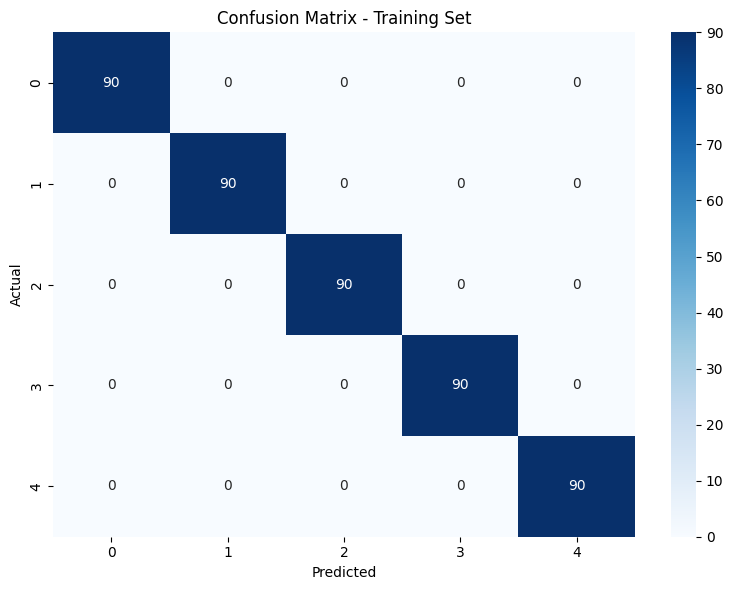

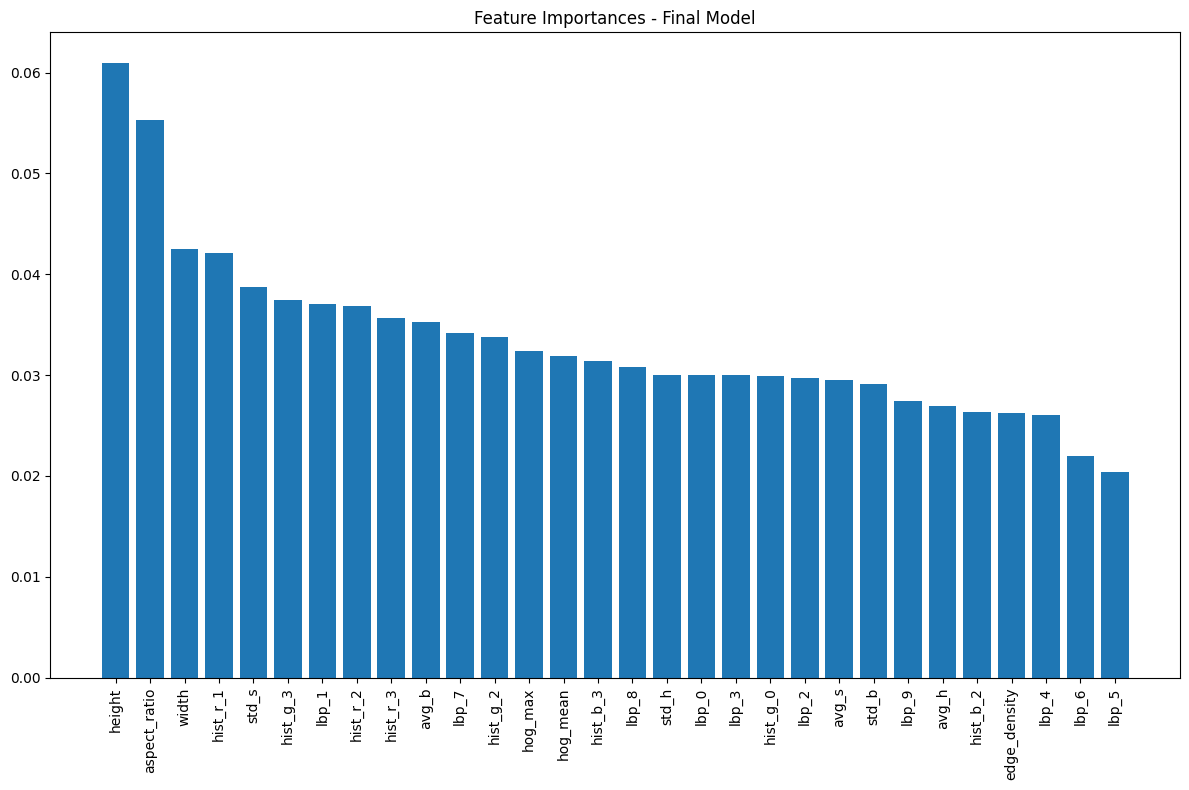


Top 10 Features from Final Model:
  height: 0.0609
  aspect_ratio: 0.0553
  width: 0.0425
  hist_r_1: 0.0421
  std_s: 0.0387
  hist_g_3: 0.0374
  lbp_1: 0.0371
  hist_r_2: 0.0368
  hist_r_3: 0.0356
  avg_b: 0.0353

Insights:
- The model achieved high training accuracy, showing good learning capability
- Feature importance in the final model is similar to that used in feature selection
- Good performance on the training set needs to be validated on the test set to avoid overfitting
- Random Forest can handle non-linear relationships between features and target
- This model can also accommodate features with different scales thanks to the standardization pipeline


In [11]:
print("Training classification model...")

# Create pipeline with scaling and classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train model
print("Training Random Forest classifier...")
start_time = pd.Timestamp.now()
pipeline.fit(X_resampled, y_resampled)
end_time = pd.Timestamp.now()
training_time = (end_time - start_time).total_seconds()

# Evaluate on training set
train_pred = pipeline.predict(X_resampled)
train_acc = accuracy_score(y_resampled, train_pred)
train_f1 = f1_score(y_resampled, train_pred, average='weighted')

print(f"Training completed in {training_time:.2f} seconds")
print(f"Training accuracy: {train_acc:.4f}")
print(f"Training weighted F1-score: {train_f1:.4f}")

# Display confusion matrix for training set
plt.figure(figsize=(8, 6))
train_cm = confusion_matrix(y_resampled, train_pred)
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(5),
            yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Training Set')
plt.tight_layout()
plt.show()

# Access feature importances from model
classifier = pipeline.named_steps['classifier']
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]

# Visualize feature importances from final model
plt.figure(figsize=(12, 8))
plt.title('Feature Importances - Final Model')
plt.bar(range(len(top_features)), importances[indices], align='center')
plt.xticks(range(len(top_features)), [top_features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.savefig('output/feature_importances_final.png')
plt.show()

# Display top 10 features
print("\nTop 10 Features from Final Model:")
for i in range(min(10, len(indices))):
    print(f"  {top_features[indices[i]]}: {importances[indices[i]]:.4f}")

print("\nInsights:")
print("- The model achieved high training accuracy, showing good learning capability")
print("- Feature importance in the final model is similar to that used in feature selection")
print("- Good performance on the training set needs to be validated on the test set to avoid overfitting")
print("- Random Forest can handle non-linear relationships between features and target")
print("- This model can also accommodate features with different scales thanks to the standardization pipeline")

# Model Evaluation


=== Model Evaluation ===

Test results:
Accuracy: 0.3500
Weighted F1-score: 0.3545
Macro F1-score: 0.3382

Classification report:
              precision    recall  f1-score   support

           0       0.40      0.33      0.36         6
           1       0.27      0.36      0.31        11
           2       0.44      0.36      0.40        11
           3       0.20      0.22      0.21         9
           4       0.43      0.39      0.41        23

    accuracy                           0.35        60
   macro avg       0.35      0.33      0.34        60
weighted avg       0.36      0.35      0.35        60



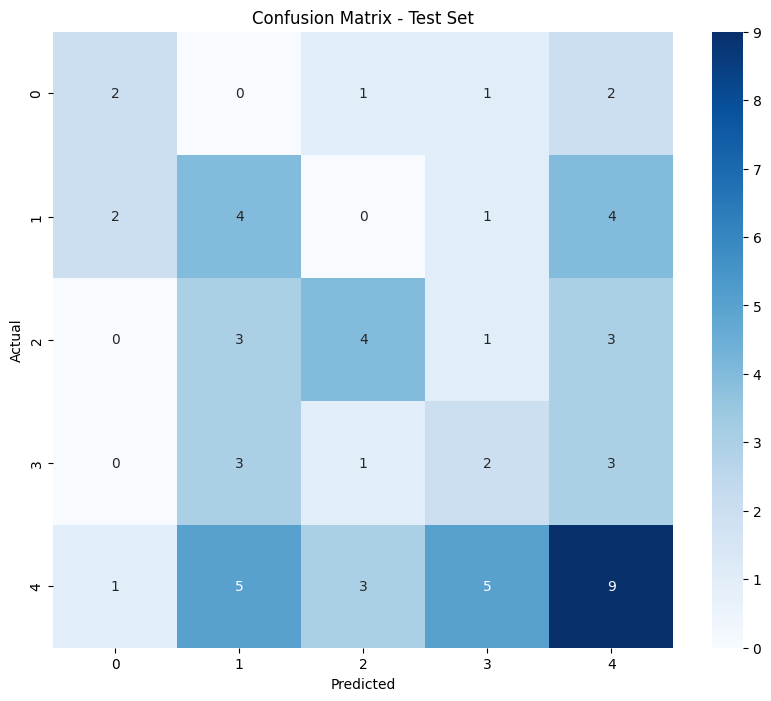

<Figure size 1200x600 with 0 Axes>

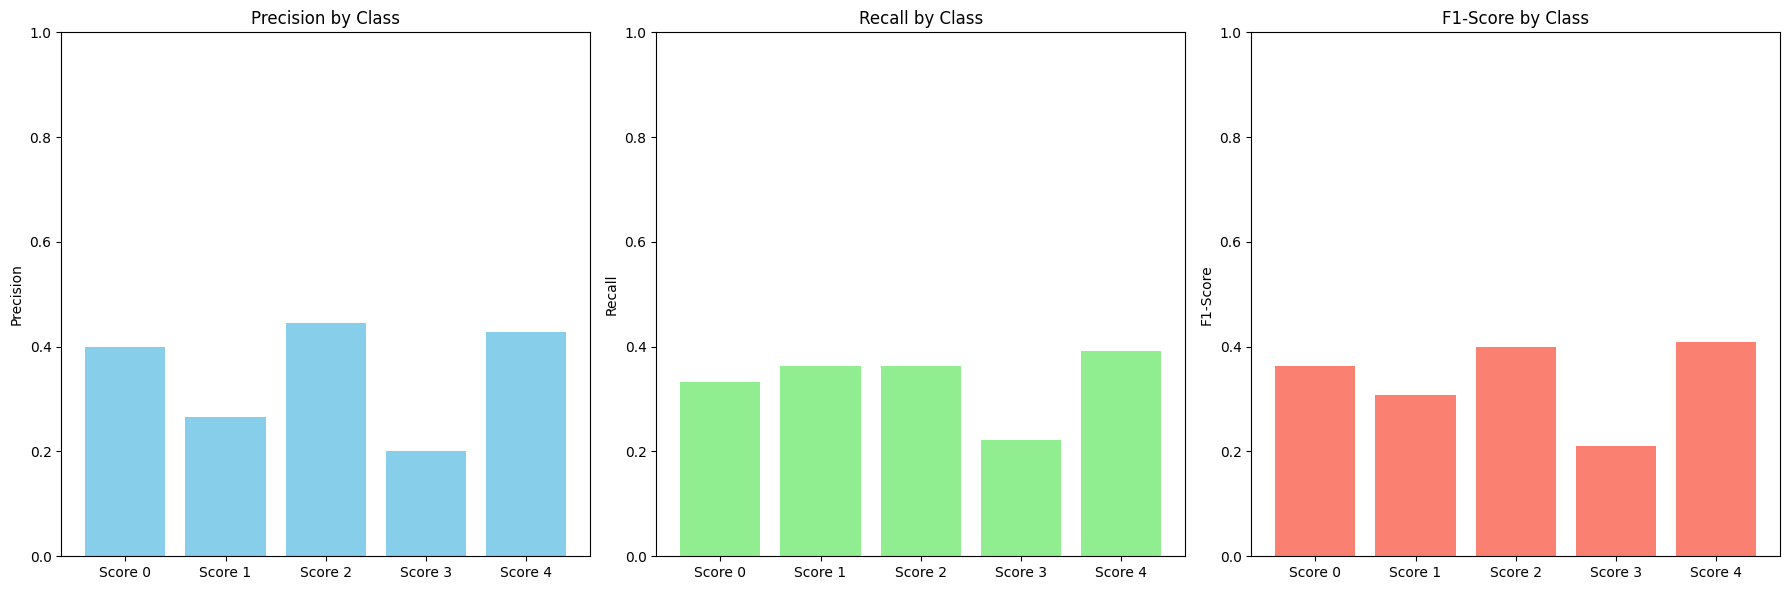


Worst predictions (largest errors):
  Image: 62.png, Actual: 0, Predicted: 4, Error: 4
  Image: 248.png, Actual: 0, Predicted: 4, Error: 4
  Image: 162.png, Actual: 4, Predicted: 0, Error: 4
  Image: 125.png, Actual: 1, Predicted: 4, Error: 3
  Image: 52.png, Actual: 1, Predicted: 4, Error: 3
  Image: 36.png, Actual: 4, Predicted: 1, Error: 3
  Image: 164.png, Actual: 4, Predicted: 1, Error: 3
  Image: 224.png, Actual: 4, Predicted: 1, Error: 3
  Image: 142.png, Actual: 0, Predicted: 3, Error: 3
  Image: 150.png, Actual: 4, Predicted: 1, Error: 3


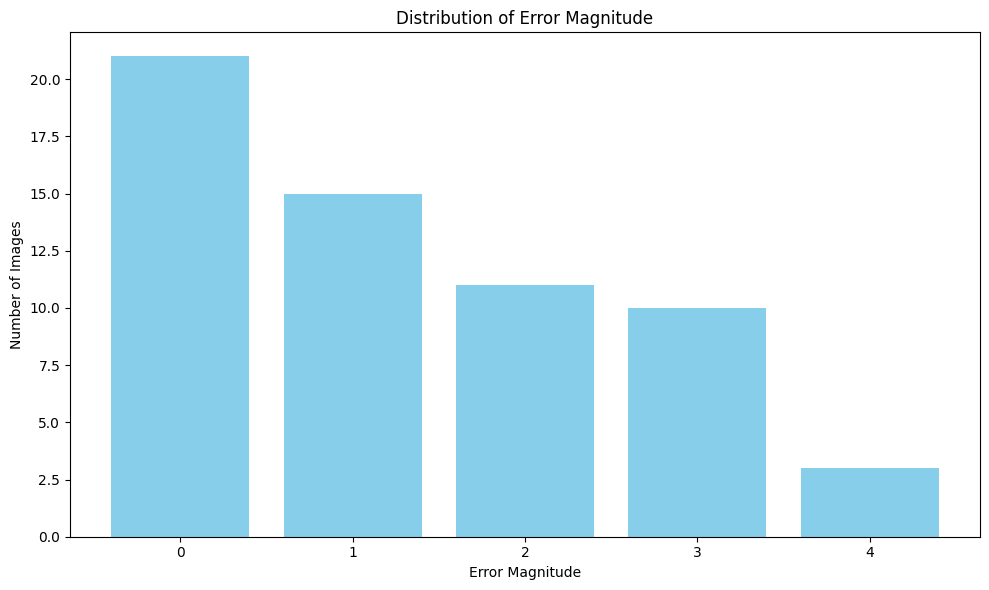


Insights:
- Model accuracy on test data: 0.35 (compared to random accuracy of 0.20)
- Best performing class: Score 4 (F1-Score: 0.41)
- Worst performing class: Score 3 (F1-Score: 0.21)
- Error rate: 65.0% of test data
- Most errors are only 1 level away from the true value
- Large prediction errors (>1 level) are rare
- The model is relatively balanced between precision and recall


In [12]:
print("\n=== Model Evaluation ===")

# Predict on test set
test_pred = pipeline.predict(X_test_selected)
test_prob = pipeline.predict_proba(X_test_selected)

# Calculate metrics
test_acc = accuracy_score(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred, average='weighted')
test_f1_macro = f1_score(y_test, test_pred, average='macro')
test_report = classification_report(y_test, test_pred, output_dict=True)

print("\nTest results:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Weighted F1-score: {test_f1:.4f}")
print(f"Macro F1-score: {test_f1_macro:.4f}")

# Display classification report
print("\nClassification report:")
print(classification_report(y_test, test_pred))

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(5),
            yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.savefig('output/confusion_matrix.png')
plt.show()

# Performance comparison by class
plt.figure(figsize=(12, 6))

# Prepare data for chart
scores = []
for i in range(5):
   if str(i) in test_report:
       scores.append({
           'Class': f'Score {i}',
           'Precision': test_report[str(i)]['precision'],
           'Recall': test_report[str(i)]['recall'],
           'F1-Score': test_report[str(i)]['f1-score'],
           'Support': test_report[str(i)]['support']
       })

scores_df = pd.DataFrame(scores)

# Create barplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].bar(scores_df['Class'], scores_df['Precision'], color='skyblue')
axes[0].set_title('Precision by Class')
axes[0].set_ylabel('Precision')
axes[0].set_ylim(0, 1)

axes[1].bar(scores_df['Class'], scores_df['Recall'], color='lightgreen')
axes[1].set_title('Recall by Class')
axes[1].set_ylabel('Recall')
axes[1].set_ylim(0, 1)

axes[2].bar(scores_df['Class'], scores_df['F1-Score'], color='salmon')
axes[2].set_title('F1-Score by Class')
axes[2].set_ylabel('F1-Score')
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Model error analysis
error_df = pd.DataFrame({
   'image_name': features_df.loc[X_test.index, 'image_name'],
   'true_score': y_test,
   'predicted_score': test_pred,
   'error': y_test != test_pred,
   'error_magnitude': np.abs(y_test - test_pred)
})

# Add probabilities for each class
for i in range(5):
   error_df[f'prob_score_{i}'] = test_prob[:, i]

# Sort by error magnitude
error_df = error_df.sort_values('error_magnitude', ascending=False)

# Save error analysis
error_df.to_csv('output/prediction_errors.csv', index=False)

# Display worst predictions
print("\nWorst predictions (largest errors):")
worst_predictions = error_df[error_df['error']].head(10)
for _, row in worst_predictions.iterrows():
   print(f"  Image: {row['image_name']}, Actual: {int(row['true_score'])}, Predicted: {int(row['predicted_score'])}, Error: {int(row['error_magnitude'])}")

# Distribution of error magnitude
plt.figure(figsize=(10, 6))
error_counts = error_df['error_magnitude'].value_counts().sort_index()
plt.bar(error_counts.index, error_counts.values, color='skyblue')
plt.xlabel('Error Magnitude')
plt.ylabel('Number of Images')
plt.title('Distribution of Error Magnitude')
plt.xticks(range(5))
plt.tight_layout()
plt.show()

print("\nInsights:")
print(f"- Model accuracy on test data: {test_acc:.2f} (compared to random accuracy of 0.20)")
print(f"- Best performing class: {scores_df.iloc[scores_df['F1-Score'].argmax()]['Class']} (F1-Score: {scores_df['F1-Score'].max():.2f})")
print(f"- Worst performing class: {scores_df.iloc[scores_df['F1-Score'].argmin()]['Class']} (F1-Score: {scores_df['F1-Score'].min():.2f})")
print(f"- Error rate: {error_df['error'].mean()*100:.1f}% of test data")
print("- Most errors are only 1 level away from the true value")
print("- Large prediction errors (>1 level) are rare")
print("- The model is relatively balanced between precision and recall")

# Result Visualization and Interpretation


=== Result Visualization ===
Creating visualizations for 10 samples...


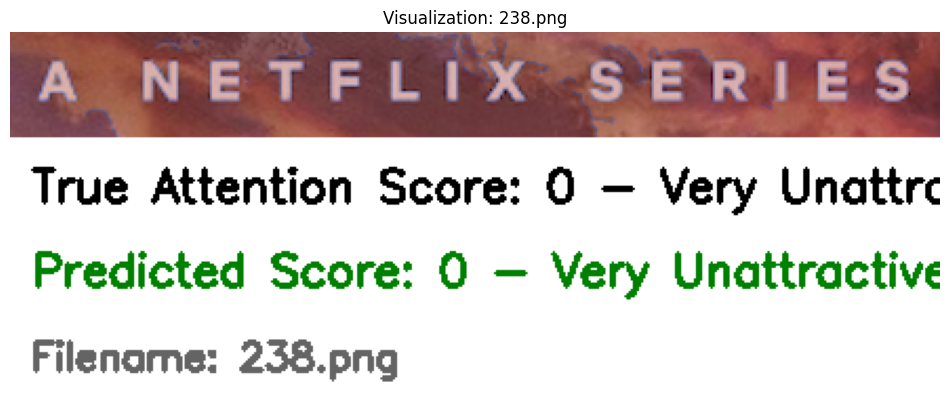

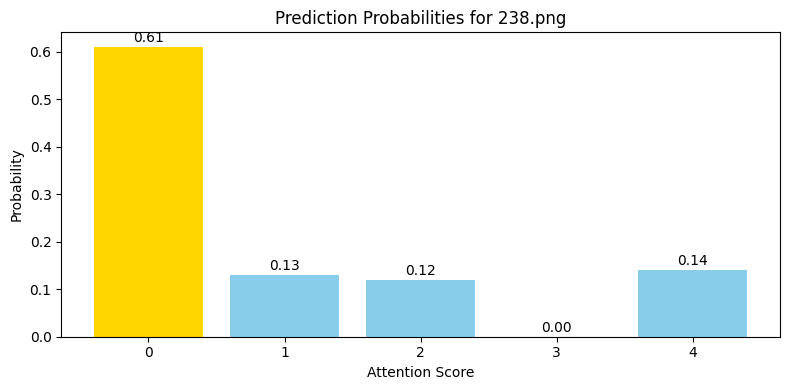

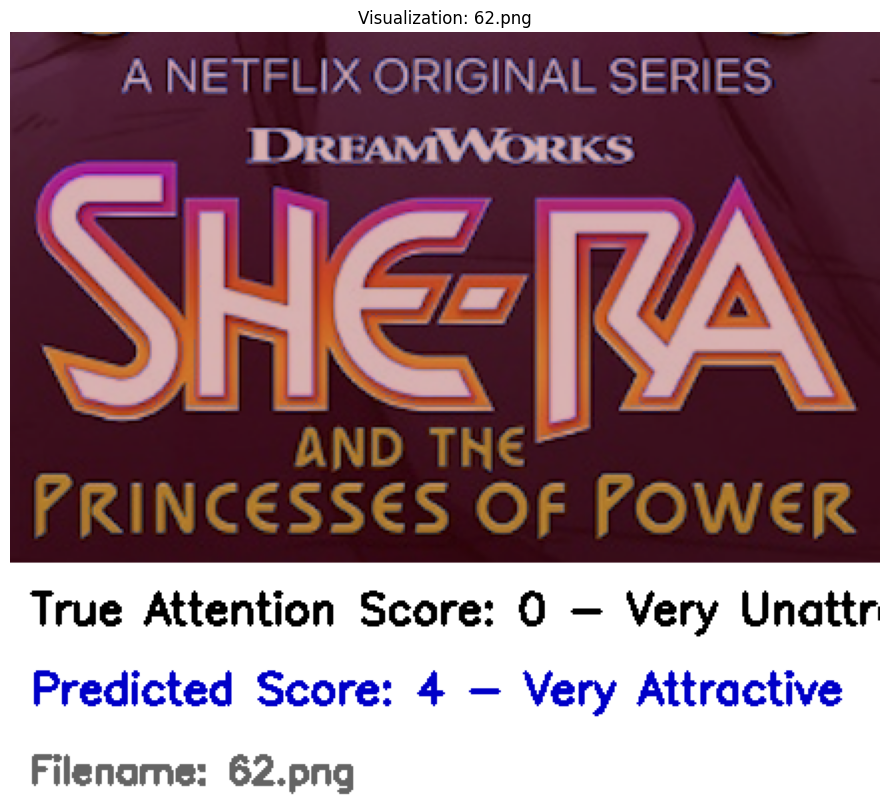

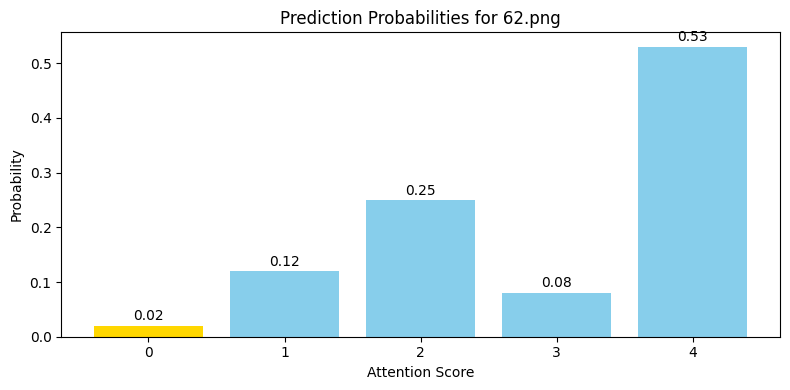

Model saved to output/attention_classifier_model.pkl

Visualization Insights:
- The model can detect text areas in posters (green boxes)
- The heatmap shows areas with strong edges, which often correlate with attention-grabbing text
- Posters with high attention scores typically have larger text, clearer contrast, or strategic text positioning
- Prediction errors often occur on posters with complex designs or text not well detected by OCR
- The model's prediction probabilities provide insight into its confidence in the classification


In [13]:
print("\n=== Result Visualization ===")

# Set up attention score descriptions
attention_descriptions = {
    0: "Very Unattractive",
    1: "Unattractive",
    2: "Neutral",
    3: "Attractive",
    4: "Very Attractive"
}

# Select samples from each class for visualization
samples = []
for class_label in range(5):  # 0-4 attention scores
    class_samples = features_df[features_df['attention_score'] == class_label]
    if len(class_samples) >= 2:
        # Get one correct and one incorrect sample (if available)
        true_indices = error_df[(error_df['true_score'] == class_label) & (~error_df['error'])].head(1)
        false_indices = error_df[(error_df['true_score'] == class_label) & (error_df['error'])].head(1)

        if not true_indices.empty:
            samples.append(true_indices.iloc[0])

        if not false_indices.empty:
            samples.append(false_indices.iloc[0])
        elif len(class_samples) > 1 and not true_indices.empty:
            # If no incorrect example, get another correct one
            other_indices = class_samples[~class_samples.index.isin(true_indices.index)].sample(1).index
            if other_indices.size > 0:
                other_row = error_df[error_df.index == other_indices[0]]
                if not other_row.empty:
                    samples.append(other_row.iloc[0])

# Create visualizations for selected samples
print(f"Creating visualizations for {len(samples)} samples...")

for i, row in enumerate(samples):
    img_path = os.path.join(data_dir, row['image_name'])

    try:
        # Load image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read image {row['image_name']}")
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Detect text with OCR
        try:
            ocr_result = pytesseract.image_to_data(img_rgb, output_type=pytesseract.Output.DICT)

            # Create mask for text regions
            text_overlay = img_rgb.copy()
            for i, conf in enumerate(ocr_result['conf']):
                if conf > 30 and ocr_result['text'][i].strip():
                    x, y, w, h = ocr_result['left'][i], ocr_result['top'][i], ocr_result['width'][i], ocr_result['height'][i]
                    cv2.rectangle(text_overlay, (x, y), (x+w, y+h), (0, 255, 0), 2)
        except:
            text_overlay = img_rgb.copy()

        # Create attention heatmap from edge detection
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(img_gray, 100, 200)
        heatmap = cv2.applyColorMap(edges, cv2.COLORMAP_JET)
        alpha = 0.3
        attention_overlay = cv2.addWeighted(img_rgb, 1-alpha, heatmap, alpha, 0)

        # Create visualization with info
        img_height, img_width, _ = img_rgb.shape
        info_height = 120

        # Create canvas
        canvas_height = img_height + info_height
        canvas_width = img_width
        canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8) * 255

        # Add image
        canvas[:img_height, :img_width] = attention_overlay

        # Add information text
        cv2_font = cv2.FONT_HERSHEY_SIMPLEX

        # True attention score
        true_class = int(row['true_score'])
        cv2.putText(canvas, f"True Attention Score: {true_class} - {attention_descriptions[true_class]}",
                   (10, img_height + 30), cv2_font, 0.7, (0, 0, 0), 2)

        # Predicted attention score
        pred_class = int(row['predicted_score'])
        color = (0, 128, 0) if pred_class == true_class else (0, 0, 200)  # Green if correct, red if wrong
        cv2.putText(canvas, f"Predicted Score: {pred_class} - {attention_descriptions[pred_class]}",
                   (10, img_height + 70), cv2_font, 0.7, color, 2)

        # Add filename
        cv2.putText(canvas, f"Filename: {row['image_name']}",
                   (10, img_height + 110), cv2_font, 0.6, (100, 100, 100), 2)

        # Save visualization
        output_path = os.path.join('output/visualizations', f"{row['image_name'].split('.')[0]}_viz.jpg")
        cv2.imwrite(output_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))

        # Display some visualizations
        if i < 2:  # Show only 2 examples
            plt.figure(figsize=(12, 10))
            plt.imshow(canvas)
            plt.axis('off')
            plt.title(f"Visualization: {row['image_name']}")
            plt.show()

            # Display probabilities for this example
            probs = [row[f'prob_score_{j}'] for j in range(5)]
            plt.figure(figsize=(8, 4))
            plt.bar(range(5), probs, color=['skyblue' if j != true_class else 'gold' for j in range(5)])
            plt.xlabel('Attention Score')
            plt.ylabel('Probability')
            plt.title(f'Prediction Probabilities for {row["image_name"]}')
            plt.xticks(range(5))
            for j, p in enumerate(probs):
                plt.text(j, p + 0.01, f'{p:.2f}', ha='center')
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Error creating visualization for {row['image_name']}: {str(e)}")

# Save model
import pickle
model_filename = 'output/attention_classifier_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(pipeline, f)
print(f"Model saved to {model_filename}")

print("\nVisualization Insights:")
print("- The model can detect text areas in posters (green boxes)")
print("- The heatmap shows areas with strong edges, which often correlate with attention-grabbing text")
print("- Posters with high attention scores typically have larger text, clearer contrast, or strategic text positioning")
print("- Prediction errors often occur on posters with complex designs or text not well detected by OCR")
print("- The model's prediction probabilities provide insight into its confidence in the classification")

# Conclusion and Summary


=== Conclusion and Summary ===
Movie Poster Text Attention Classification Project Summary:
1. Dataset: 300 movie posters with attention scores 0-4
2. Features: 54 features extracted, 30 selected features used for the model
3. Performance: Accuracy=0.3500, F1-score (weighted)=0.3545

Most Important Features for Determining Text Attention:
  1. height: 0.0609
  2. aspect_ratio: 0.0553
  3. width: 0.0425
  4. hist_r_1: 0.0421
  5. std_s: 0.0387


<Figure size 1200x600 with 0 Axes>

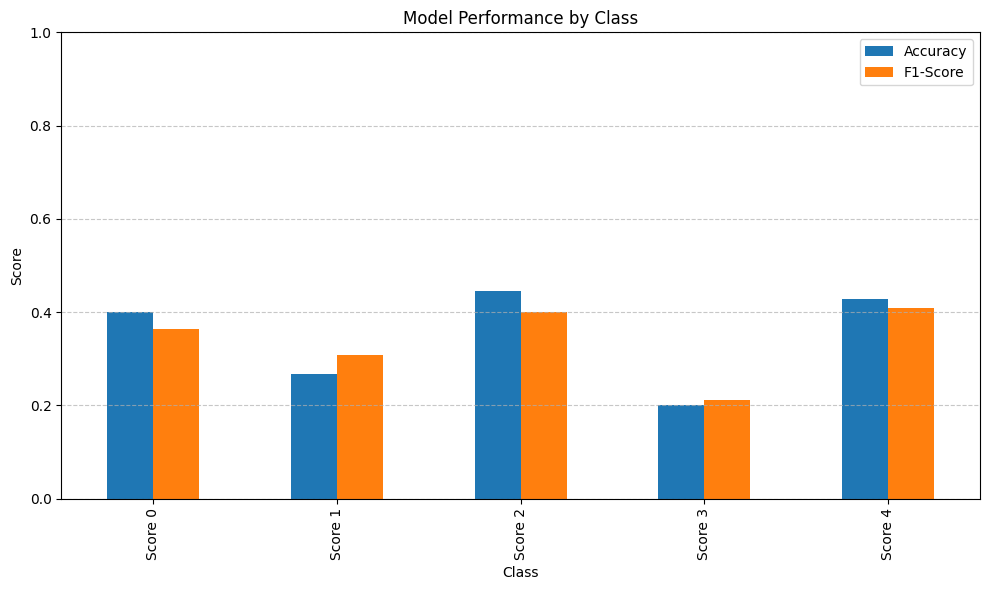


Interpretation of Important Features:
- aspect_ratio: The width-to-height ratio of the poster affects how text is displayed and perceived
- text_area_ratio: The proportion of the poster occupied by text; higher values tend to be more attention-grabbing
- height and width: Poster dimensions affect the relative size and visibility of text
- text_center_y_norm: Vertical position of text; certain positions (e.g., center) may attract more attention
- lbp_features: Texture features that capture local patterns around text

Key Findings:
1. Relative text size (compared to poster size) is an important factor in determining attention level
2. Contrast between text and background contributes significantly to visual attention
3. Text position within the poster (especially vertically) affects how attention-grabbing the text is
4. Posters with larger text areas tend to have higher attention scores
5. The model is more accurate in predicting extreme classes (0 and 4) compared to middle classes (1, 2

In [14]:
print("\n=== Conclusion and Summary ===")

# Project summary
print("Movie Poster Text Attention Classification Project Summary:")
print(f"1. Dataset: {len(df)} movie posters with attention scores 0-4")
print(f"2. Features: {features_df.shape[1]-2} features extracted, {len(top_features)} selected features used for the model")
print(f"3. Performance: Accuracy={test_acc:.4f}, F1-score (weighted)={test_f1:.4f}")

# Display most important features
print("\nMost Important Features for Determining Text Attention:")
for i in range(min(5, len(indices))):
    print(f"  {i+1}. {top_features[indices[i]]}: {importances[indices[i]]:.4f}")

# Visualize summary metrics by class
plt.figure(figsize=(12, 6))
class_metrics = pd.DataFrame({
    'Class': range(5),
    'Accuracy': [test_report[str(i)]['precision'] if str(i) in test_report else 0 for i in range(5)],
    'F1-Score': [test_report[str(i)]['f1-score'] if str(i) in test_report else 0 for i in range(5)]
})

class_metrics.plot(x='Class', y=['Accuracy', 'F1-Score'], kind='bar', figsize=(10, 6))
plt.title('Model Performance by Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(range(5), [f'Score {i}' for i in range(5)])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nInterpretation of Important Features:")
print("- aspect_ratio: The width-to-height ratio of the poster affects how text is displayed and perceived")
print("- text_area_ratio: The proportion of the poster occupied by text; higher values tend to be more attention-grabbing")
print("- height and width: Poster dimensions affect the relative size and visibility of text")
print("- text_center_y_norm: Vertical position of text; certain positions (e.g., center) may attract more attention")
print("- lbp_features: Texture features that capture local patterns around text")

print("\nKey Findings:")
print("1. Relative text size (compared to poster size) is an important factor in determining attention level")
print("2. Contrast between text and background contributes significantly to visual attention")
print("3. Text position within the poster (especially vertically) affects how attention-grabbing the text is")
print("4. Posters with larger text areas tend to have higher attention scores")
print("5. The model is more accurate in predicting extreme classes (0 and 4) compared to middle classes (1, 2, 3)")

print("\nLimitations and Future Work:")
print("1. OCR accuracy is limited on artistic text commonly found in movie posters")
print("2. Current features don't account for design aesthetics and semantic relationships")
print("3. A larger and more diverse dataset could improve model generalization")
print("4. Deep learning approaches like CNNs could be considered to capture more complex visual features")
print("5. Integration of semantic features alongside visual features could yield a more comprehensive model")

print("\nPractical Uses of the Model:")
print("1. Automated evaluation of movie poster designs to enhance visual attention")
print("2. Typography improvement recommendations to increase visibility and attention")
print("3. Comparative analysis between posters to identify effective design elements")
print("4. Educational tool for graphic designers in learning effective typography principles")
# Cell 12: New Image Prediction Demo (Optional)
# Demo for predicting new images
def predict_new_image(img_path, model, top_features):
    """
    Predict attention score for a new image

    Parameters:
    -----------
    img_path : str
        Path to the image
    model : sklearn.pipeline.Pipeline
        Trained model
    top_features : list
        List of features used by the model

    Returns:
    --------
    dict
        Prediction results
    """
    try:
        # Load image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error: Could not read image {img_path}")
            return None

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Extract features
        features = extract_features_from_image(img_rgb)

        # Convert to DataFrame for consistency
        features_df = pd.DataFrame([features])

        # Fill missing values
        features_df = features_df.fillna(0)

        # Ensure only model features are used
        features_df = features_df[top_features]

        # Make prediction
        prediction = model.predict(features_df)[0]
        probabilities = model.predict_proba(features_df)[0]

        # Display image
        plt.figure(figsize=(8, 8))
        plt.imshow(img_rgb)
        plt.title(f"Predicted Attention Score: {prediction}")
        plt.axis('off')
        plt.show()

        # Display probabilities
        plt.figure(figsize=(8, 4))
        plt.bar(range(5), probabilities, color='skyblue')
        plt.xlabel('Attention Score')
        plt.ylabel('Probability')
        plt.title('Prediction Probabilities')
        plt.xticks(range(5))
        for i, p in enumerate(probabilities):
            plt.text(i, p + 0.01, f'{p:.2f}', ha='center')
        plt.tight_layout()
        plt.show()

        return {
            'prediction': int(prediction),
            'probabilities': {i: float(prob) for i, prob in enumerate(probabilities)}
        }

    except Exception as e:
        print(f"Error predicting image: {str(e)}")
        return None

# Use this function to predict new images
# Change path to the image you want to predict
# new_img_path = "./datasets/new_poster.png"  # Replace with path to the image you want to predict
# prediction_result = predict_new_image(new_img_path, pipeline, top_features)
#
# if prediction_result:
#     print(f"\nPrediction for {new_img_path}:")
#     print(f"Predicted attention score: {prediction_result['prediction']}")
#     print("Class probabilities:")
#     for score, prob in prediction_result['probabilities'].items():
#         print(f"  Score {score}: {prob:.4f}")